In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score

import scipy.cluster.hierarchy as hac 


In [2]:
def zscore_bseline(input_mat):
    use_unit_z = np.zeros(input_mat.shape)
    for item in range(input_mat.shape[0]):
        use_unit = input_mat[item]
        unit_baseline = use_unit[0:1500]
        unit_baseline_mean = np.mean(unit_baseline)
        unit_baseline_std = np.std(unit_baseline)
        use_unit_z[item] = (use_unit - unit_baseline_mean)/unit_baseline_std
    return use_unit_z

In [3]:
all_unit_ave_activity = loadmat("processed_data/all_unit_ave_activity.mat")
cue_mat_1 = all_unit_ave_activity['cue_mat_1']
cue_mat_all = all_unit_ave_activity['cue_mat_all']
cue_mat_1_sem = all_unit_ave_activity['cue_mat_1_sem']
cue_mat_all_sem = all_unit_ave_activity['cue_mat_all_sem']

In [4]:
all_unit_activity_sig = loadmat("processed_data/all_unit_activity_sig.mat")
spike_mat_sig_all = all_unit_activity_sig['spike_mat_sig_all']
pval_all = all_unit_activity_sig['pval_all']
fval_all = all_unit_activity_sig['fval_all']


In [5]:
sig_mat = np.zeros((spike_mat_sig_all.shape[0], 4))

num_criteria = 10

for item in range(spike_mat_sig_all.shape[0]):
    unique, counts = np.unique(spike_mat_sig_all[item, 1500:3000], return_counts=True)
    if -1 in unique:
        if dict(zip(unique, counts))[-1] > num_criteria:
            sig_mat[item, 0] = 1
    if 1 in unique:
        if dict(zip(unique, counts))[1] > num_criteria:
            sig_mat[item, 1] = 1
            
    unique, counts = np.unique(spike_mat_sig_all[item, 3000:], return_counts=True)
    if -1 in unique:
        if dict(zip(unique, counts))[-1] > num_criteria:
            sig_mat[item, 2] = 1
    if 1 in unique:
        if dict(zip(unique, counts))[1] > num_criteria:
            sig_mat[item, 3] = 1
            
#sig_mat = pd.DataFrame(sig_mat)
#sig_mat.columns = ['Cue_ini', 'Cue_act', 'Speech_ini', 'Speech_act']


In [6]:
cv_encoding_unit = np.repeat(0, sig_mat.shape[0])
sig_diff_cv = np.array([28, 48, 122, 176, 184, 185, 189, 199, 30, 129, 168])

for item in range(len(cv_encoding_unit)):
    if item in sig_diff_cv:
        cv_encoding_unit[item] = 1
cv_encoding_unit = cv_encoding_unit.reshape(len(cv_encoding_unit), 1)

In [7]:
beta_supp_unit = np.repeat(0, sig_mat.shape[0])
sig_beta_supp = np.array([26, 30, 48, 56, 64, 117, 129, 131, 148, 153, 160, 162, 171, 188, 199])

for item in range(len(beta_supp_unit)):
    if item in sig_beta_supp:
        beta_supp_unit[item] = 1
beta_supp_unit = beta_supp_unit.reshape(len(beta_supp_unit), 1)

In [8]:
sig_mat = np.concatenate((sig_mat, cv_encoding_unit, beta_supp_unit), axis=1)
sig_mat.shape


(205, 6)

In [9]:
cue_speech_encoding_unit = pd.read_csv("cue_speech_encoding_unit.csv", index_col='Unnamed: 0').iloc[22:, :-2]
cue_speech_encoding_unit.head()
cue_speech_encoding_unit.shape

,SubjectID,session,unit_id,unit,Cue,Cue dir,Speech,Speech dir,Grade,cv_encoding_auditory,cv_encoding_speech,beta
22,DBS3003,1,1,1,NaN,NaN,Before,+,C,0.0,0.0,0.0
23,DBS3003,1,2,1,NaN,NaN,Before,+,C,0.0,0.0,0.0
24,DBS3003,1,3,1,After,+,Before,+,A,0.0,0.0,0.0
25,DBS3003,1,4,2,NaN,NaN,Before,+,C,0.0,0.0,0.0
26,DBS3003,1,5,3,After,-,Before,+,A,0.0,1.0,1.0


(207, 12)

In [10]:
sig_mat = np.zeros((cue_speech_encoding_unit.shape[0], 9))

for item in range(cue_speech_encoding_unit.shape[0]):
    if cue_speech_encoding_unit.iloc[item, 5] == '-':
        sig_mat[item, 0] = 1
    elif cue_speech_encoding_unit.iloc[item, 5] == '+':
        sig_mat[item, 1] = 1
    elif cue_speech_encoding_unit.iloc[item, 5] == 'Mixed':
        sig_mat[item, 0] = 1
        sig_mat[item, 1] = 1
    else:
        sig_mat[item, 2] = 0.5
    if cue_speech_encoding_unit.iloc[item, 7] == '-':
        sig_mat[item, 3] = 1
    elif cue_speech_encoding_unit.iloc[item, 7] == '+':
        sig_mat[item, 4] = 1
    else:
        sig_mat[item, 5] = 0.5
    if cue_speech_encoding_unit.iloc[item, 9] == 1:
        sig_mat[item, 6] = 1
    if cue_speech_encoding_unit.iloc[item, 10] == 1:
        sig_mat[item, 7] = 1
    if cue_speech_encoding_unit.iloc[item, 11] == 1:
        sig_mat[item, 8] = 1

In [11]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [12]:
sig_mat[7], sig_mat[6] = sig_mat[6], sig_mat[7]

In [13]:
sig_mat_pd = pd.DataFrame(sig_mat)
sig_mat_pd = swap_columns(sig_mat_pd, 6, 7)
sig_mat_pd = sig_mat_pd.sort_values(by = [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [69]:
sig_mat

array([[0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 1. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0.5, ..., 1. , 1. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ]])

In [72]:
sig_mat_pd

,0,1,2,3,4,5,7,6,8
0,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
202,0.0,0.0,0.5,0.0,1.0,0.0,0.0,0.0,0.0
203,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0
204,0.0,0.0,0.5,0.0,1.0,0.0,1.0,1.0,0.0
205,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0


<AxesSubplot:>

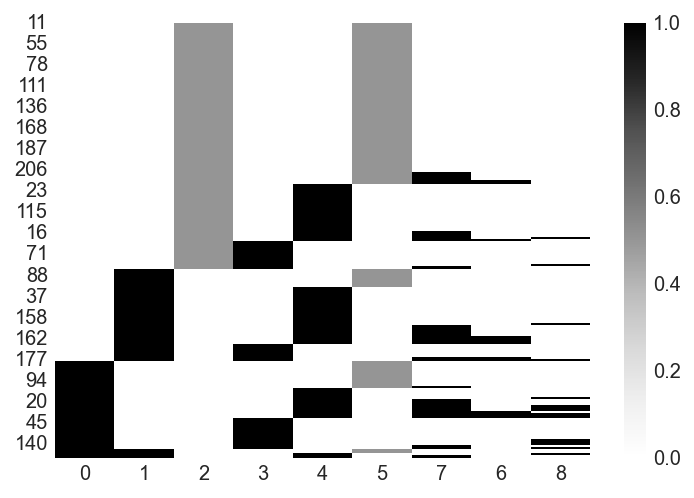

In [73]:
sns.heatmap(sig_mat_pd.sort_values(by = [0, 1, 2, 3, 4, 5, 6, 7, 8]), cmap='Greys')

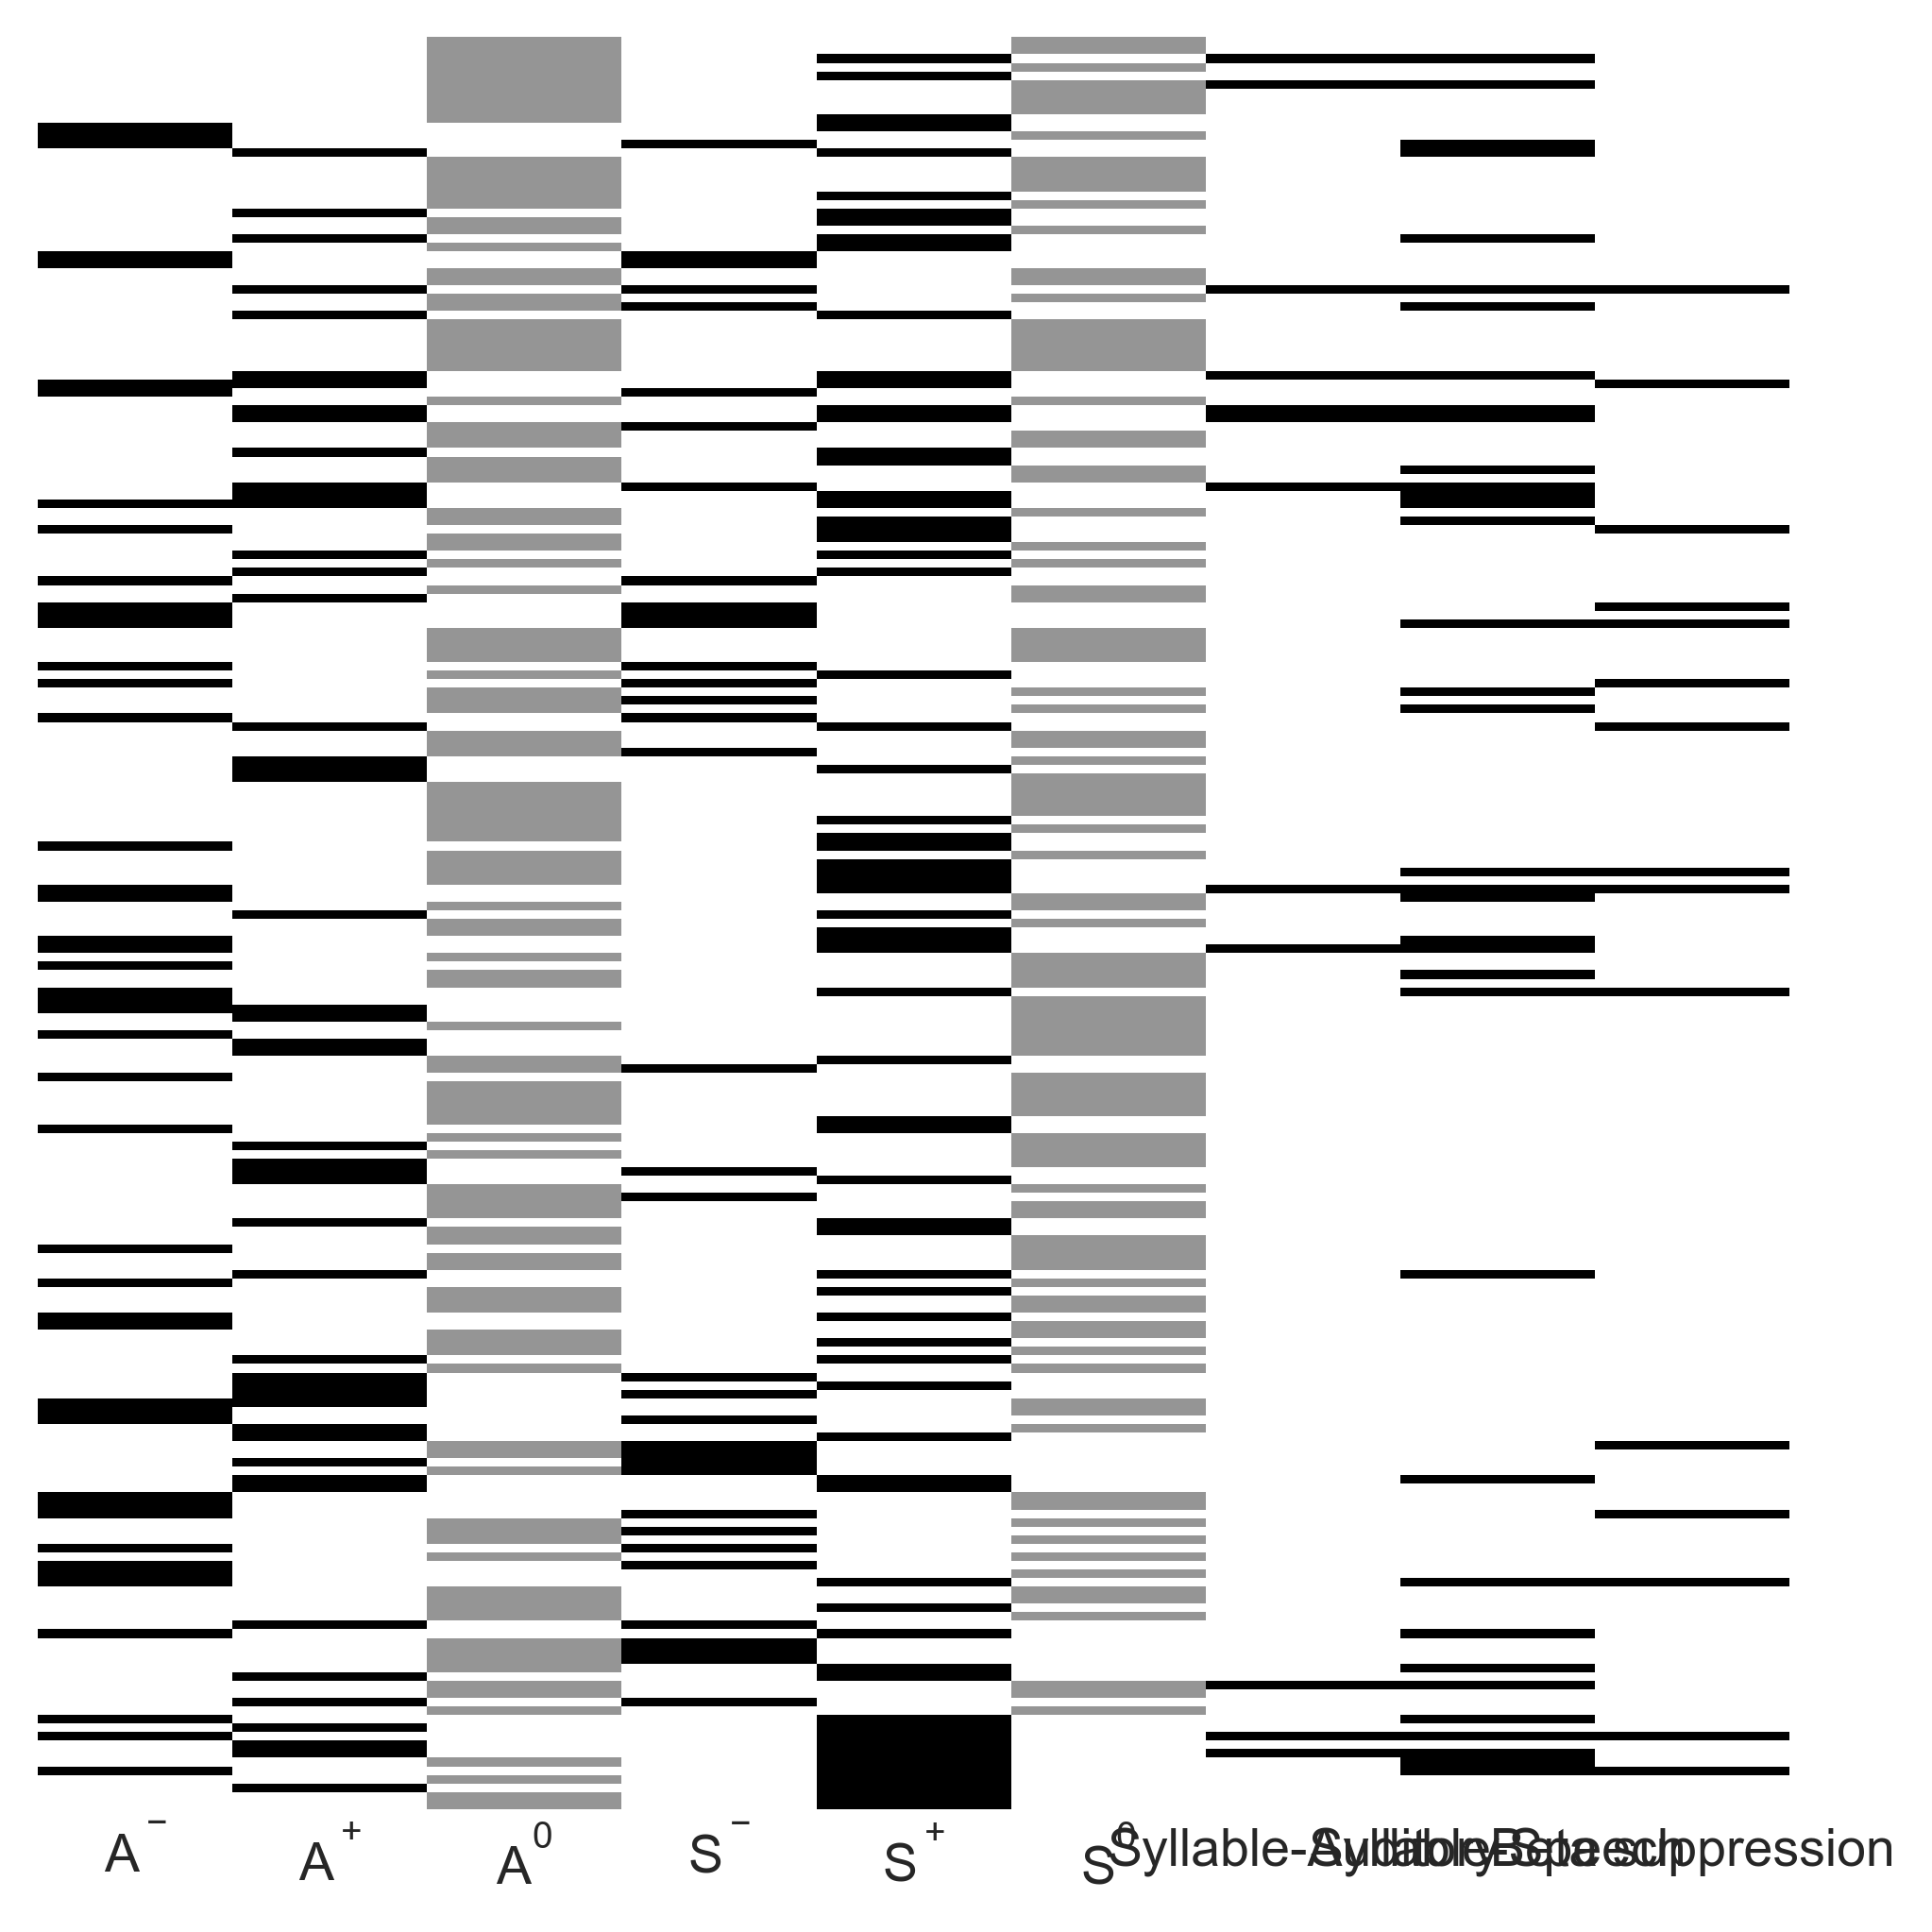

In [53]:

fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=200, constrained_layout=True)

sns.heatmap(sig_mat, cmap='Greys', ax=axs, cbar=False)

axs.invert_yaxis()
axs.set_yticks([])
axs.set_xticklabels(['$\mathregular{A^-}$', '$\mathregular{A^+}$', '$\mathregular{A^0}$', 
                     '$\mathregular{S^-}$', '$\mathregular{S^+}$', '$\mathregular{S^0}$', 
                     'Syllable-Auditory', 'Syllable-Speech', 'Beta suppression'], rotation=0)

plt.show();

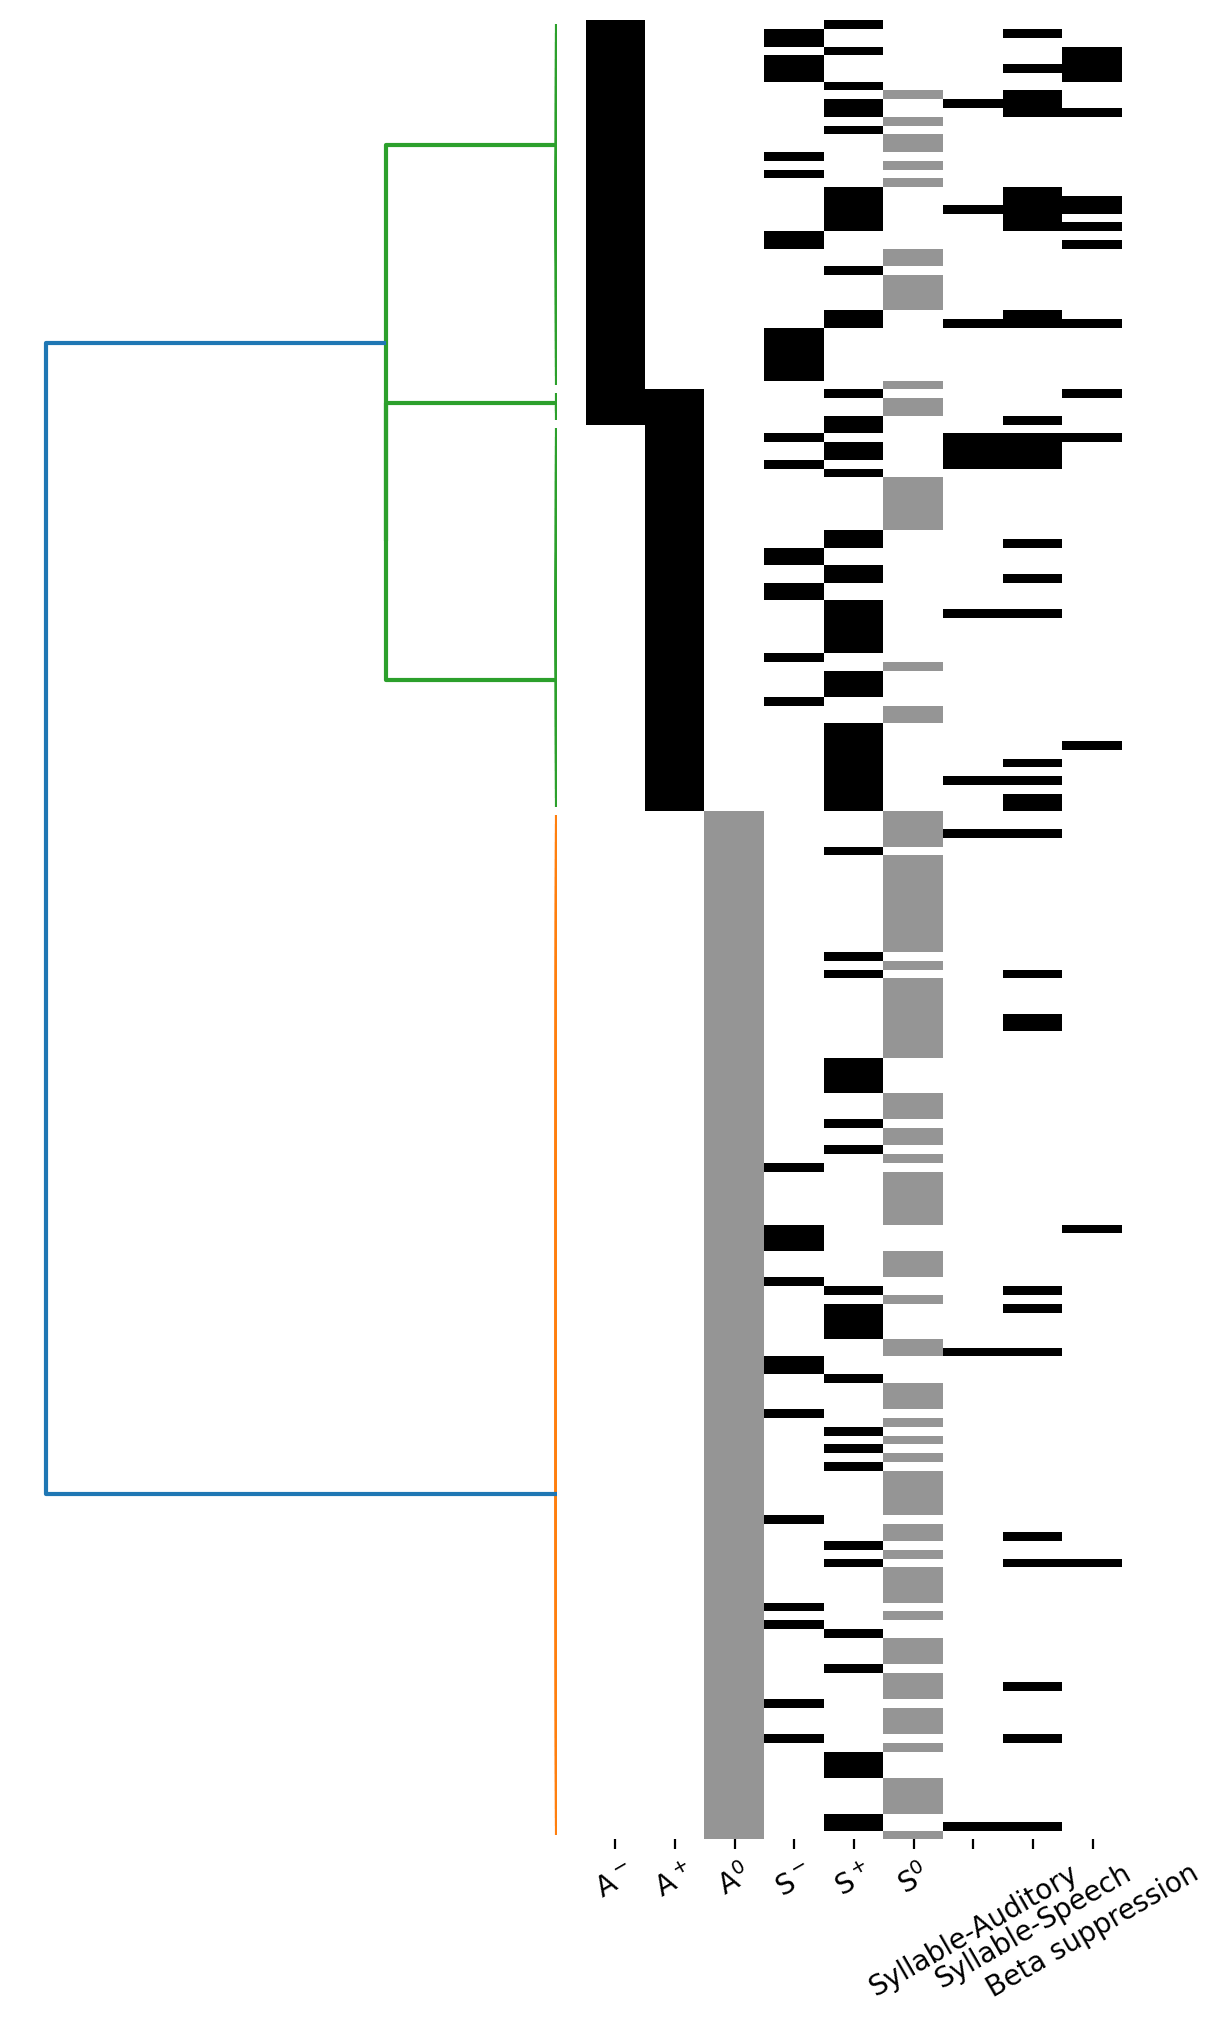

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 10), dpi=200, constrained_layout=True)
use_cmap = sns.diverging_palette(220, 20, as_cmap=1, sep=125)
fig.patch.set_alpha(0)

Z = hac.linkage(sig_mat[:, :3], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], orientation='left', no_labels=1)

cos_ordered_units = np.zeros(sig_mat.shape)
for item in range(sig_mat.shape[0]):
    cos_ordered_units[item] = sig_mat[dn['leaves'][item]]
    
sns.heatmap(cos_ordered_units, cmap='Greys', cbar=False, 
            ax=axs[1], yticklabels=False, xticklabels=500)
axs[1].invert_yaxis()
axs[0].axis('off')
#axs[1].axvline(1500, color='k', linewidth=0.75)
axs[1].set_xticks(np.linspace(0.5, 8.5, 9))
axs[1].set_xticklabels(['$\mathregular{A^-}$', '$\mathregular{A^+}$', '$\mathregular{A^0}$', 
                     '$\mathregular{S^-}$', '$\mathregular{S^+}$', '$\mathregular{S^0}$', 
                     'Syllable-Auditory', 'Syllable-Speech', 'Beta suppression'], rotation=30)

plt.show();

In [14]:
Z = hac.linkage(sig_mat[:, :3], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], orientation='left', no_labels=1)

cos_ordered_units = np.zeros(sig_mat.shape)
for item in range(sig_mat.shape[0]):
    cos_ordered_units[item] = sig_mat[dn['leaves'][item]]
    
cos_ordered_units_no_mix = []
cos_ordered_units_mix = []
for item in range(cos_ordered_units.shape[0]):
    if cos_ordered_units[item, 0] + cos_ordered_units[item, 1] == 2:
        cos_ordered_units_mix.append(cos_ordered_units[item])
    else:
        cos_ordered_units_no_mix.append(cos_ordered_units[item])
        
cos_ordered_units_no_mix = np.array(cos_ordered_units_no_mix)
cos_ordered_units_mix = np.array(cos_ordered_units_mix)

NameError: name 'axs' is not defined

In [ ]:
Z = hac.linkage(sig_mat[:, :3], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], orientation='left', no_labels=1)

cos_ordered_units = np.zeros(sig_mat.shape)
for item in range(sig_mat.shape[0]):
    cos_ordered_units[item] = sig_mat[dn['leaves'][item]]
    
cos_ordered_units_no_mix = []
cos_ordered_units_mix = []
for item in range(cos_ordered_units.shape[0]):
    if cos_ordered_units[item, 0] + cos_ordered_units[item, 1] == 2:
        cos_ordered_units_mix.append(cos_ordered_units[item])
    else:
        cos_ordered_units_no_mix.append(cos_ordered_units[item])
        
cos_ordered_units_no_mix = np.array(cos_ordered_units_no_mix)
cos_ordered_units_mix = np.array(cos_ordered_units_mix)
    
l2_a_minus = cos_ordered_units_no_mix[cos_ordered_units_no_mix[:, 0] == 1]
Z = hac.linkage(l2_a_minus[:, 3:6], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, no_plot=1)
l2_a_minus_ordered = np.zeros(l2_a_minus.shape)
for item in range(l2_a_minus_ordered.shape[0]):
    l2_a_minus_ordered[item] = l2_a_minus[dn['leaves'][item]]
    
Z = hac.linkage(cos_ordered_units_mix[:, 3:6], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, no_plot=1)
l2_mix_ordered = np.zeros(cos_ordered_units_mix.shape)
for item in range(l2_mix_ordered.shape[0]):
    l2_mix_ordered[item] = cos_ordered_units_mix[dn['leaves'][item]]

l2_a_plus = cos_ordered_units_no_mix[cos_ordered_units_no_mix[:, 1] == 1]
Z = hac.linkage(l2_a_plus[:, 3:6], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, no_plot=1)
l2_a_plus_ordered = np.zeros(l2_a_plus.shape)
for item in range(l2_a_plus_ordered.shape[0]):
    l2_a_plus_ordered[item] = l2_a_plus[dn['leaves'][item]]
    
l2_a_zero = cos_ordered_units_no_mix[cos_ordered_units_no_mix[:, 2] == 0.5]
Z = hac.linkage(l2_a_zero[:, 3:6], metric='correlation', optimal_ordering=1, method='single')
dn = hac.dendrogram(Z, no_plot=1)
l2_a_zero_ordered = np.zeros(l2_a_zero.shape)
for item in range(l2_a_zero_ordered.shape[0]):
    l2_a_zero_ordered[item] = l2_a_zero[dn['leaves'][item]]


In [ ]:
ordered_mat = np.concatenate((l2_a_minus_ordered, l2_mix_ordered, 
                              l2_a_plus_ordered, l2_a_zero_ordered), axis=0)

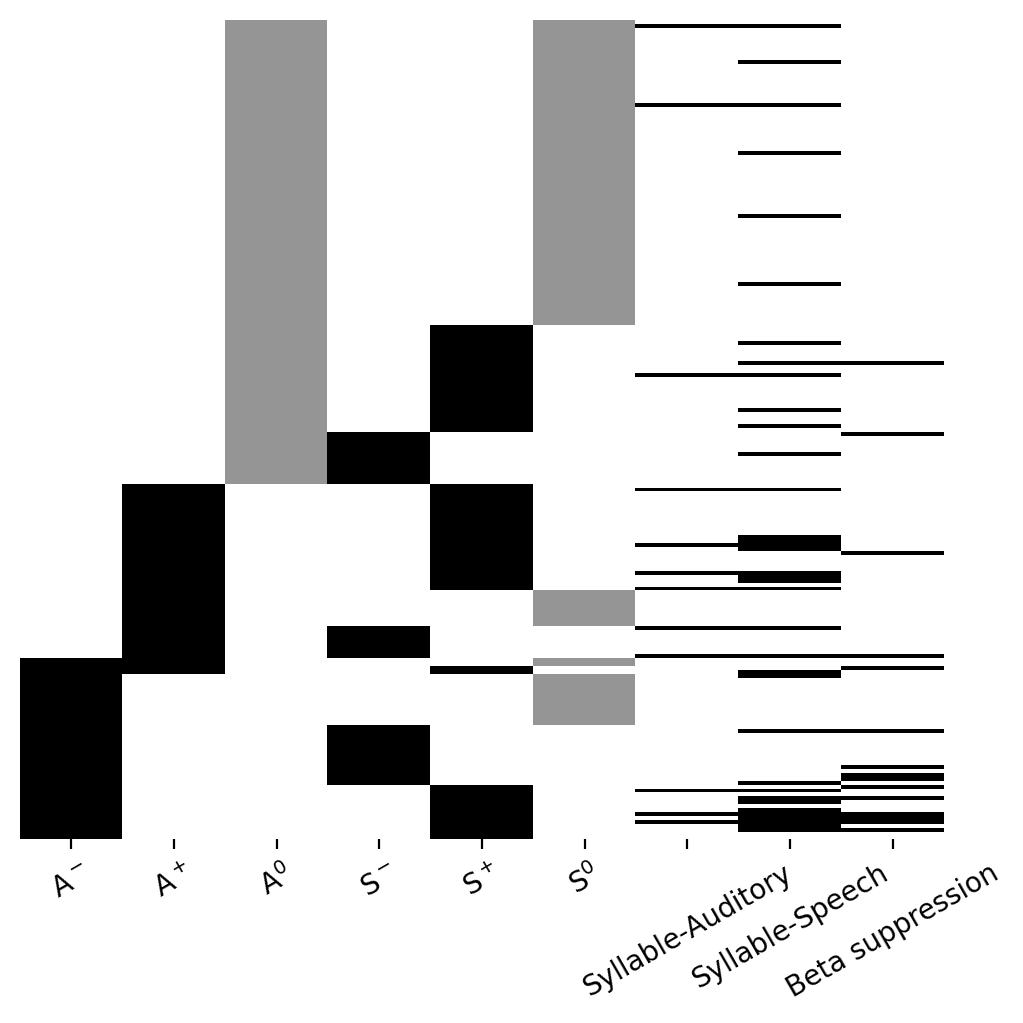

In [29]:

fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=200, constrained_layout=True)

sns.heatmap(ordered_mat, cmap='Greys', ax=axs, cbar=False)

axs.invert_yaxis()
axs.set_yticks([])
axs.set_xticklabels(['$\mathregular{A^-}$', '$\mathregular{A^+}$', '$\mathregular{A^0}$', 
                     '$\mathregular{S^-}$', '$\mathregular{S^+}$', '$\mathregular{S^0}$', 
                     'Syllable-Auditory', 'Syllable-Speech', 'Beta suppression'], rotation=30)

plt.show();

In [79]:
sig_mat_pd.shape

(207, 9)

In [86]:
np.array(sig_mat_pd)

array([[0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       [0. , 0. , 0.5, ..., 0. , 0. , 0. ],
       ...,
       [1. , 1. , 0. , ..., 0. , 0. , 0. ],
       [1. , 1. , 0. , ..., 0. , 0. , 1. ],
       [1. , 1. , 0. , ..., 1. , 0. , 0. ]])

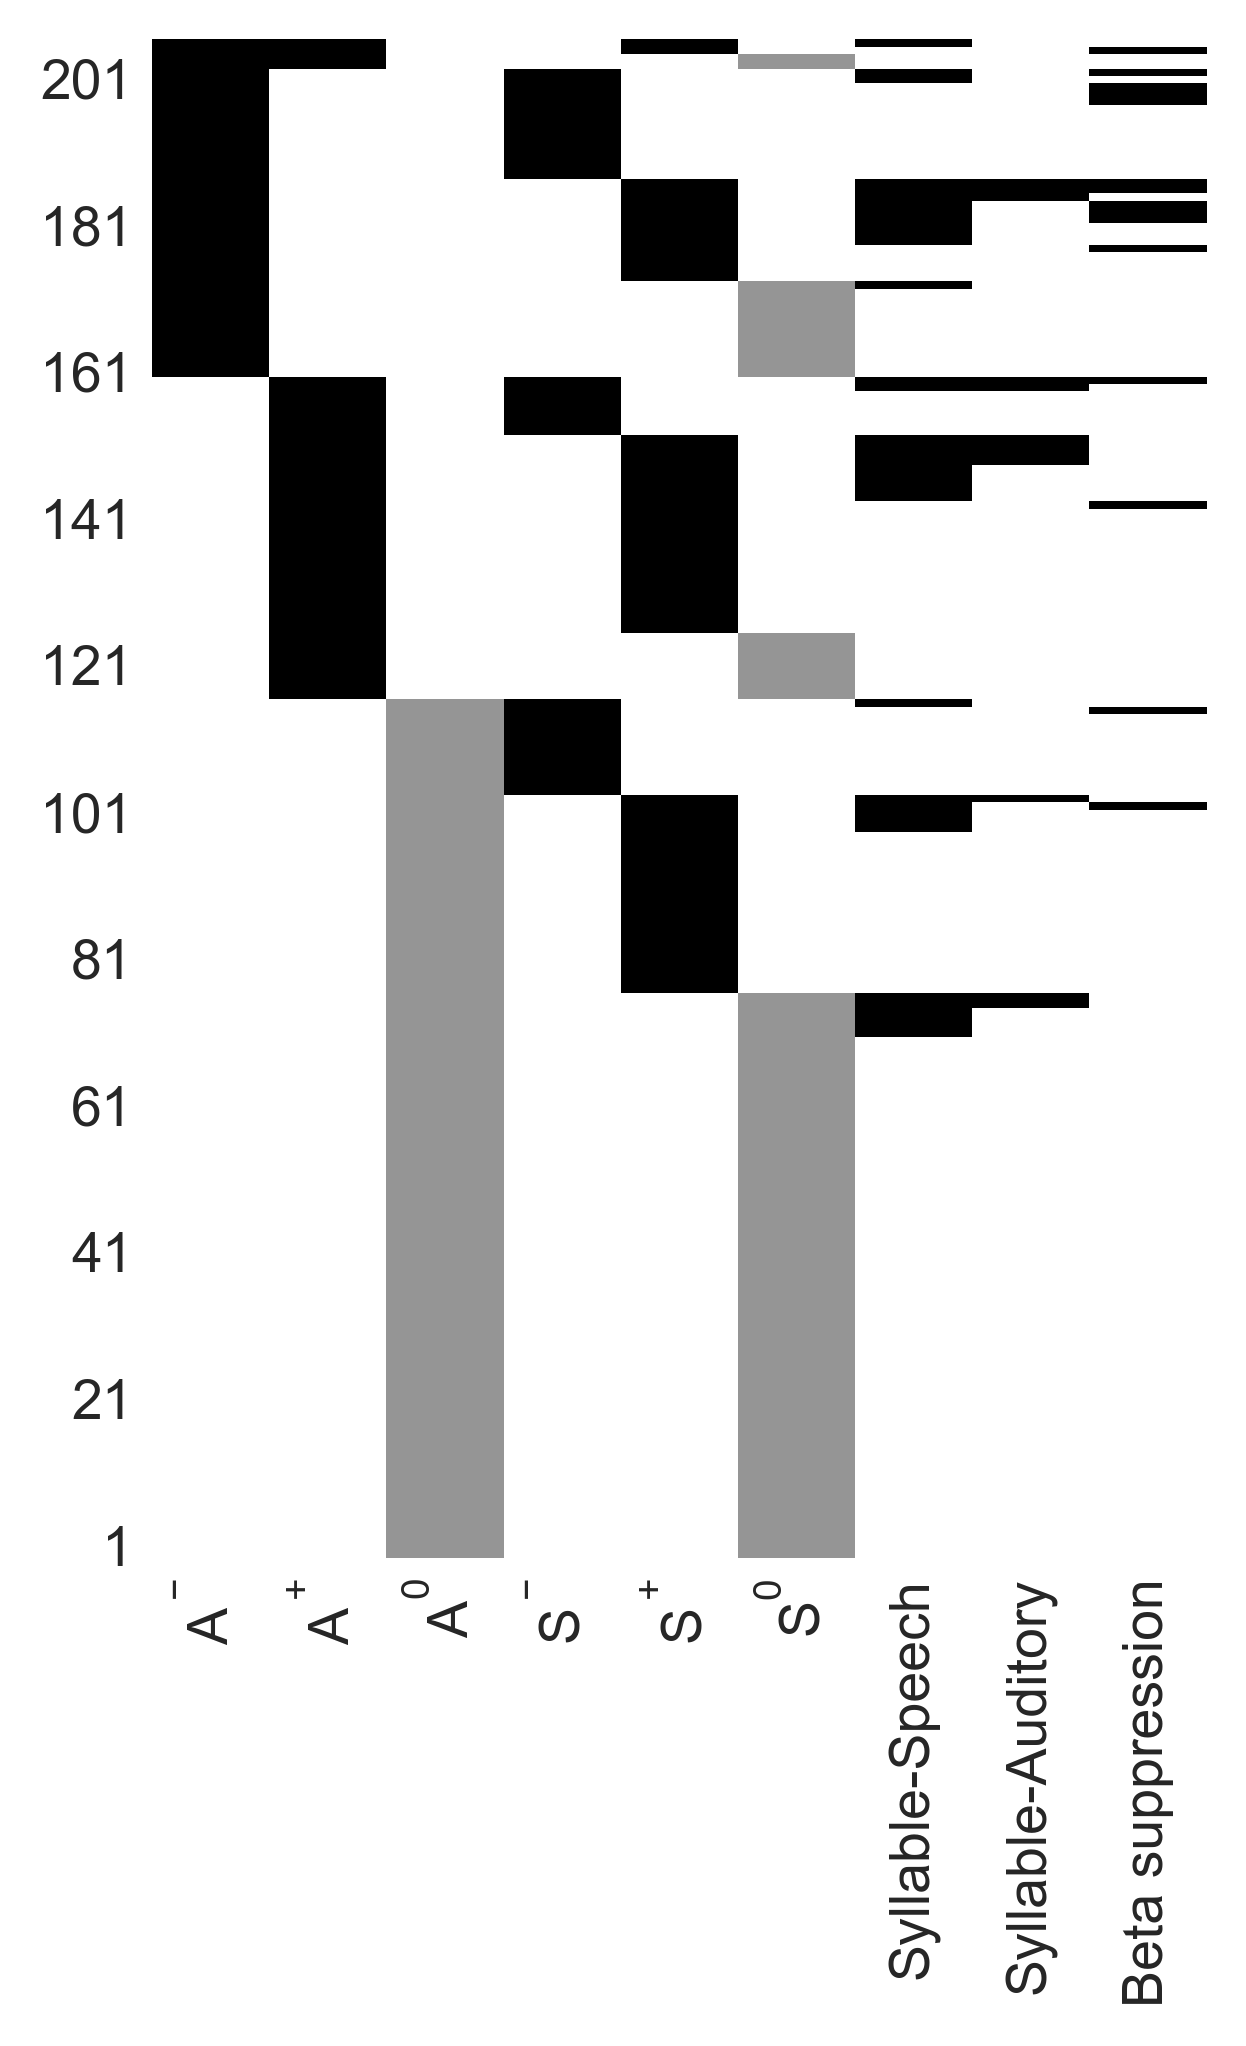

In [94]:

fig, axs = plt.subplots(1, 1, figsize=(3, 5), dpi=200, constrained_layout=True)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)
sns.heatmap(np.array(sig_mat_pd), cmap='Greys', ax=axs, cbar=False)

axs.invert_yaxis()
axs.set_yticks(np.linspace(1, 201, 11))
axs.set_yticklabels(np.linspace(1, 201, 11, dtype=int))
axs.set_xticklabels(['$\mathregular{A^-}$', '$\mathregular{A^+}$', '$\mathregular{A^0}$', 
                     '$\mathregular{S^-}$', '$\mathregular{S^+}$', '$\mathregular{S^0}$', 
                     'Syllable-Speech', 'Syllable-Auditory', 'Beta suppression'], rotation=90)

plt.show();

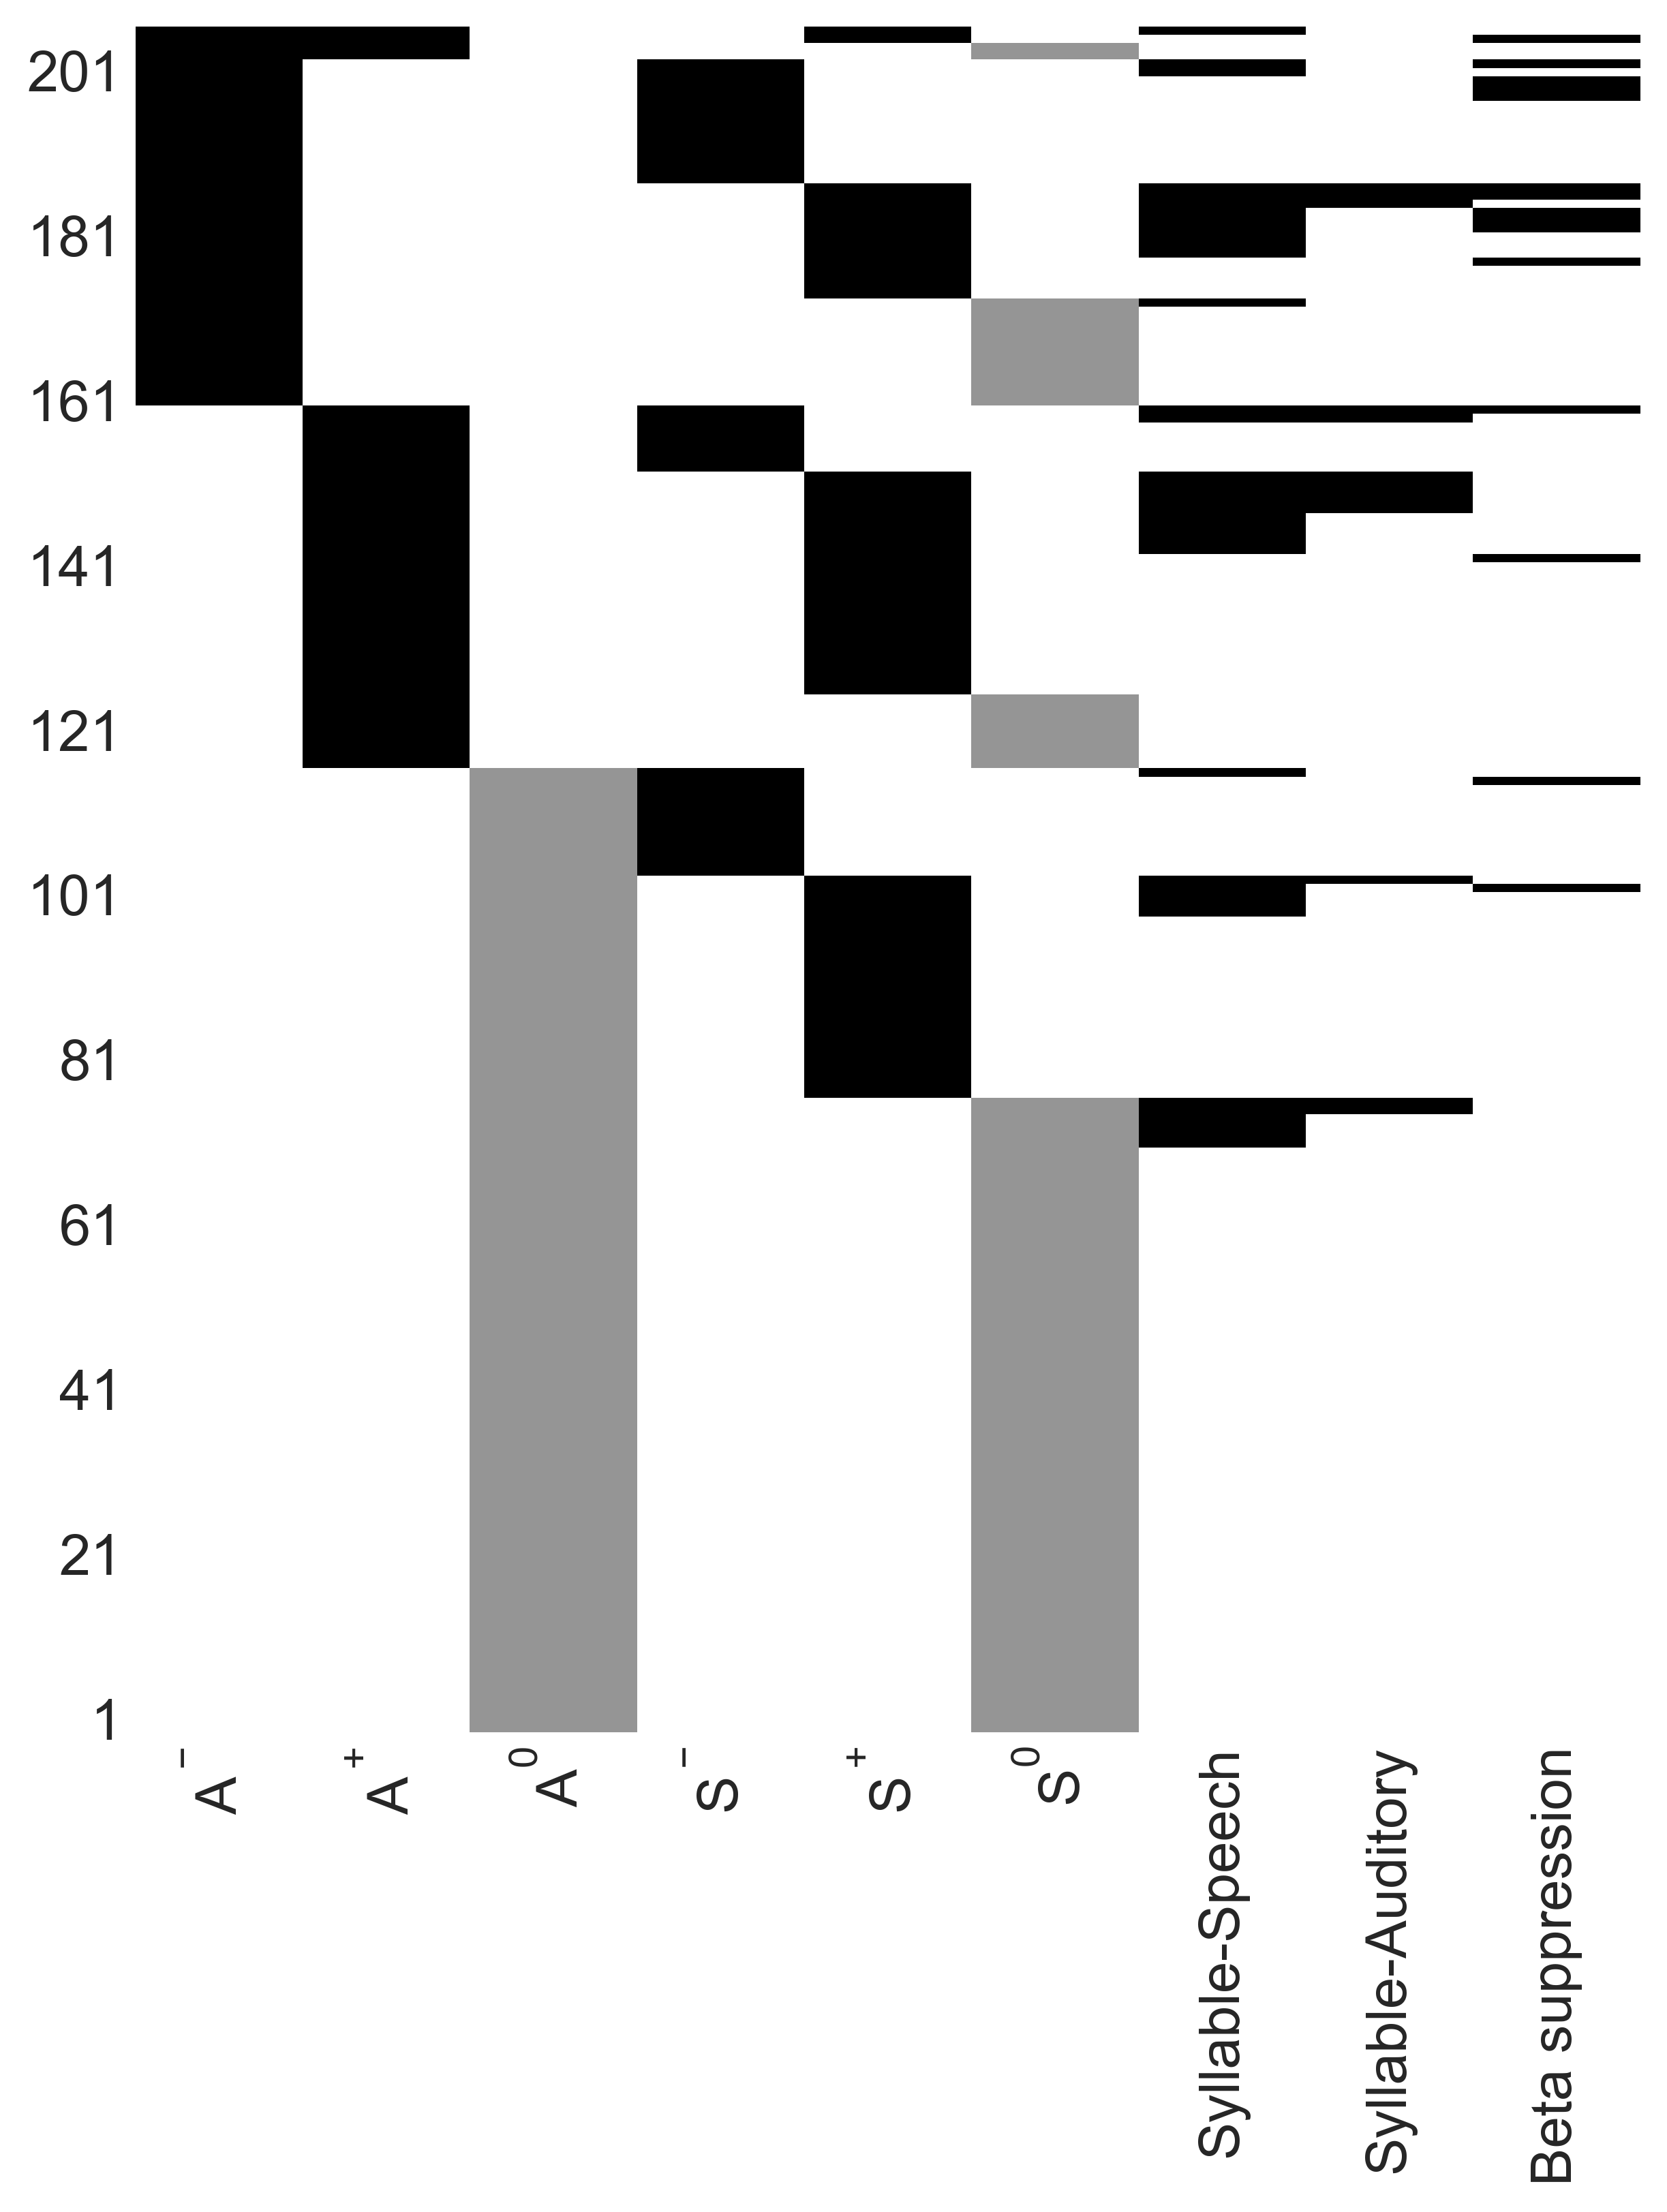

In [16]:

fig, axs = plt.subplots(1, 1, figsize=(6, 8), dpi=200, constrained_layout=True)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)
sns.heatmap(np.array(sig_mat_pd), cmap='Greys', ax=axs, cbar=False)

axs.invert_yaxis()
axs.set_yticks(np.linspace(1, 201, 11))
axs.set_yticklabels(np.linspace(1, 201, 11, dtype=int), fontsize=15)
axs.set_xticklabels(['$\mathregular{A^-}$', '$\mathregular{A^+}$', '$\mathregular{A^0}$', 
                     '$\mathregular{S^-}$', '$\mathregular{S^+}$', '$\mathregular{S^0}$', 
                     'Syllable-Speech', 'Syllable-Auditory', 'Beta suppression'], rotation=90, fontsize=15)

plt.savefig("../plots/fig5a.svg", format = 'svg', dpi=200);
